# ANN for Multi-Class Classification

Until now we have seen ANN in a regression setting. The loss function that we used for training was the MSE (Mean Squared Error). The standard loss function for multi-class classification is the Cross-Entropy Loss (also known as Log Loss) and first let's understand what it is.

## Entropy and Cross-Entropy

In evaluating a model's accuracy, we need a measure between our model's prediction and a perfect (out-of-sample) prediction. This measure should be able to account for the fact that some outcomes (targets) are easier to predict than others. Consider the task of predicting the weather (sunshine/rain) in a desert, where it almost never rains. A model that always predicts sunshine will be correct most of the time, but it is not a very useful model as you will always be surprised when it rains.

The *entropy* of a distribution is a measure of its uncertainty that has four properties

- It is **zero** if the distribution is degenerate (i.e. the outcome is always sunshine)
- It is **continuous**, so a small change in the distribution will result in a small change in the entropy
- It is **higher** for distributions which can produce **more outcomes** than for distributions that can produce fewer outcomes
- It is **additive**, so the entropy of a distribution is the sum of the entropies of its components. This means that if we first measure the uncertainty about being male/female and then measure the uncertainty about being a soccer fan or not, the uncertainty of the combinations (male/soccer fan, male/not soccer fan, female/soccer-fan, female/not soccer fan) should the sum of the two uncertainties.

It is easy to show that the entropy defined as the expected value of the log-probabilities of the outcomes satisfies these four properties.

$$
H(P) = -\sum_{k} p_k \log p_k \\
E(\log \text{ prob}) = -\sum_{k} p_k \log p_k
$$


In [195]:
import numpy as np
import matplotlib.pyplot as plt

p0 = np.array([1])

p1 = np.array([1/2, 1/2])

p2 = np.array([1/100, 99/100])

p3 = np.array([1/3, 1/3, 1/3])

H_p0 = - np.sum(p0 * np.log(p0))
print(f"H_p0: {H_p0:.4f}")

H_p1 = - np.sum(p1 * np.log(p1))
print(f"H_p1: {H_p1:.4f}")

H_p2 = - np.sum(p2 * np.log(p2))
print(f"H_p2: {H_p2:.4f}")

H_p3 = - np.sum(p3 * np.log(p3))
print(f"H_p3: {H_p3:.4f}")

H_p0: -0.0000
H_p1: 0.6931
H_p2: 0.0560
H_p3: 1.0986


In [196]:
# Example with DEPENDENT variables
# Strong correlation: Soccer fans tend to be female

# Marginal distributions
p_female = 0.4
p_male = 1 - p_female
p_gender = np.array([p_male, p_female])

p_fan = 0.7
p_not_fan = 1 - p_fan
p_soccer = np.array([p_fan, p_not_fan])

# DEPENDENT joint distribution (not independent)
# Males: mostly NOT fans (90% not fans)
# Females: mostly fans (80% fans)
p_joint_dependent = np.array([
    0.06,   # Male & Fan (10% of 60%)
    0.54,   # Male & Not Fan (90% of 60%)
    0.32,   # Female & Fan (80% of 40%)
    0.08    # Female & Not Fan (20% of 40%)
])

p_joint_independent = np.array([
    p_male * p_fan,
    p_male * p_not_fan,
    p_female * p_fan,
    p_female * p_not_fan
])

def entropy(p):
    """Calculate entropy, handling zero probabilities"""
    p = p[p > 0]
    return -np.sum(p * np.log(p))

H_gender = entropy(p_gender)
H_soccer = entropy(p_soccer)
H_joint_dependent = entropy(p_joint_dependent)
H_joint_independent = entropy(p_joint_independent)

print(f"H(Gender) = {H_gender:.4f}")
print(f"H(Soccer Fan) = {H_soccer:.4f}")
print(f"H(Gender) + H(Soccer) = {H_gender + H_soccer:.4f}")
print(f"H(Gender, Soccer) (independent) = {H_joint_independent:.4f}")
print(f"H(Gender, Soccer) (dependent) = {H_joint_dependent:.4f}")

H(Gender) = 0.6730
H(Soccer Fan) = 0.6109
H(Gender) + H(Soccer) = 1.2839
H(Gender, Soccer) (independent) = 1.2839
H(Gender, Soccer) (dependent) = 1.0682


So the entropy gives us the uncertainty when predicting outcomes using the true distribution (in other words: how difficult it is to predict values from this distribution). When we build prediction models, however, we don't know the distribution generating the outcomes. Instead, we rely on the model to provide probabilities that we hope are close to the true probabilities. 

We can ask: how much does the uncertainty increase if we use a different (from P) distribution  instead of the true probabilities to predict the outcomes? This is the *cross-entropy*.

$$
H(P, Q) = -\sum_{k} p_k \log q_k
$$

It can also be decomposed into the entropy of the true distribution and the Kullback-Leibler divergence between the true distribution and the model distribution.

$$
H(P, Q) = H(P) + \text{KL}(P, Q)
$$

In the above expression, H(p) is the entropy of the data-generating distribution, and KL(p, q) is the Kullback-Leibler divergence between the data-generating distribution and the model distribution. The KL divergence is always non-negative, and it is zero if the two distributions are identical. Therefore, the cross-entropy is always greater than or equal to the entropy of the data-generating distribution.

$$
\text{KL}(P, Q) = \sum_{k} p_k (\log p_k - \log q_k) = \sum_{i} p_k \log \frac{p_k}{q_k}
$$

The KL-divergence describes how different P and Q are on average (in units of entropy). You have likely encountered a scaled version of it when studying generalized linear models (GLM) under the name of *deviance*. The deviance is the KL-divergence between the data-generating distribution and the model distribution, scaled by a factor of two.  

In gradient descent, we want to minimize the cross-entropy between the true distribution (the labels) and the model distribution (the predicted probabilities). The loss function for multi-class logistic regression is the cross-entropy loss:

In [197]:
# Difficulty predicting outcomes from P using Q

P_true = np.array([0.7, 0.3])  # True distribution
Q_model1 = np.array([0.4, 0.6])  # Model's predicted distribution
Q_model2 = np.array([0.75, 0.25])  # Another model's predicted distribution

H_P = -np.sum(P_true * np.log(P_true))
H_P_Q1 = -np.sum(P_true * np.log(Q_model1))
H_P_Q2 = -np.sum(P_true * np.log(Q_model2))

print(f"Entropy H(P) = {H_P:.4f}")
print(f"Cross-Entropy H(P, Q1) = {H_P_Q1:.4f}")
print(f"Cross-Entropy H(P, Q2) = {H_P_Q2:.4f}")

Entropy H(P) = 0.6109
Cross-Entropy H(P, Q1) = 0.7947
Cross-Entropy H(P, Q2) = 0.6173


## The Bi-Gram Model

Until now we have treated text data as a sequence of tokens but ignored the order of the tokens. The TF-IDF representation only looked at _what_ words were present in a document, but not _where_ they were located and _in what order_.

Here we will begin with a very simple probabilistic language model and we will start with asking the question: what is the probability of sentence? Let's say that we want to score sentences based on how likely or unlikely they are to appear in a language (for example to detect non-sensical sentences).


In [198]:
import nltk
from nltk.corpus import gutenberg

nltk.download('gutenberg')

# Get the raw text of Alice in Wonderland
alice_text = gutenberg.raw('carroll-alice.txt')

# Show the first 1000 characters
print(alice_text[:1000])

[Alice's Adventures in Wonderland by Lewis Carroll 1865]

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Alice 'without pictures or
conversation?'

So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure
of making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a White Rabbit with pink eyes ran
close by her.

There was nothing so VERY remarkable in that; nor did Alice think it so
VERY much out of the way to hear the Rabbit say to itself, 'Oh dear!
Oh dear! I shall be late!' (when she thought it over afterwards, it
occurred to her that she ought to have wondered at this, but at the time
it all seemed quite natural); but

[nltk_data] Downloading package gutenberg to /home/amarov/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


**Alice was beginning to get very tired of sitting by her sister on the
bank.**

One simple approach could be to look at the frequency of each word in a large corpus of text and then multiply the frequencies of the words in the sentence to get an overall score. However, this is nothing more than the bag-of-words model and it ignores the order of the words. Another approach would be to treat the whole sentence as a single token and look up its frequency in a large corpus. However, you can imagine that most sentences will not appear in the corpus more than once and it will be difficult to estimate their probabilities.

A compromise between these two extremes is to look at sequences of several words and estimate the probabilities of these sequences and then combine them to get the probability of the whole sentence using the chain rule of probability.

Let's look at **Alice was beginning to get very tired** (shorter example to save space). Using the chain rule of probability, we can decompose the probability of the whole sentence into the product of conditional probabilities of each word given the previous words.

For events A and B, the conditional probability of A given B is defined as

$$
P(A \cap B) = P(A|B) P(B)
$$

For three events A, B, and C, we can extend this to

$$
P(A \cap B \cap C) = P(A|B \cap C) P(B|C) P(C)
$$

Applying this to our sentence, we get

$$
\begin{align*}
P(\text{Alice was beginning to get very tired}) & = P(\text{tired}|\text{Alice was beginning to get very})\\ 
& \times  P(\text{very}|\text{Alice was beginning to get}) \\
& \times P(\text{get}|\text{Alice was beginning to}) \\
& \times P(\text{to}|\text{Alice was beginning}) \\
& \times P(\text{beginning}|\text{Alice was}) \\
& \times P(\text{was}|\text{Alice}) \\
& \times P(\text{Alice})
\end{align*}
$$

Until now we have not made any assumptions about the dependencies between the words, we have simply restated the sentence probability using the chain rule. However, estimating these conditional probabilities is difficult because the number of possible combinations of words is very large and we will not have enough data to estimate them accurately.

We can get around this problem by making a Markov assumption: that the conditional probability of a word only depends on the previous word (this is called a first-order Markov assumption). With this assumption the probabilities above simplify to

$$
\begin{align*}
P(\text{Alice was beginning to get very tired}) & = P(\text{tired}|\text{very})\\ 
& \times  P(\text{very}|\text{get}) \\
& \times P(\text{get}|\text{to}) \\
& \times P(\text{to}|\text{beginning}) \\
& \times P(\text{beginning}|\text{was}) \\
& \times P(\text{was}|\text{Alice}) \\
& \times P(\text{Alice})
\end{align*}
$$

Now these pairs of consecutive words (called) bigrams are much easier to estimate from data. We only need to count how many times each word follows another word in a large corpus of text and divide by the total number of times the first word appears to get the conditional probability.

We could arrange the bigram probabilities in a matrix, where the rows correspond to the first word and the columns correspond to the second word. Each entry in the matrix would then contain the probability of the second word given the first word. This matrix is called a bigram model.


|           | Alice | was | beginning | to  | get | very | tired |
|-----------|-------|-----|-----------|-----|-----|------|-------|
| Alice     | -     | 1.0 | 0         | 0   | 0   | 0    | 0     |
| was       | 0     | 0   | 1.0       | 0   | 0   | 0    | 0     |
| beginning | 0     | 0   | 0         | 1.0 | 0   | 0    | 0     |
| to        | 0     | 0   | 0         | 0   | 1.0 | 0    | 0     |
| get       | 0     | 0   | 0         | 0   | 0   | 1.0  | 0     |
| very      | 0     | 0   | 0         | 0   | 0   | 0    | 1.0   |
| tired     | 0     | 0   | 0         | 0   | 0   | 0    | 0     |

## The Bi-Gram Model as a Classification Problem

Instead of directly counting bi-grams in the text we can also obtain the same probabilities by posing the problem as a classification task. Given a word, we want to predict the next word in the sequence. We can treat the unique words in the corpus just as we treat categorical variables in a regression setting: we represent the categories (words) using indicator (dummy) variables. So to predict the word **was** given the word **Alice**, we would represent **Alice** as a vector of zeros with a one in the position corresponding to **Alice** in the vocabulary and we will do the same for all other words. Let's say for a moment that we have a predictive model $f(x)$ that takes as input the indicator vector for a word and outputs a vector of predicted probabilities for the next word. 

Let the vocabulary be {Alice, beginning, get, tired, to, very, was}. Then the training sample **Alice was** would be represented as

$$
f(\text{Alice}) = f\left(
\begin{bmatrix}
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{bmatrix}
\right) =
\begin{bmatrix}
0.02 \\
0.03 \\
0.05 \\
0.05 \\
0.07 \\
0.03 \\
0.8
\end{bmatrix}
= \hat{y}_{Alice}
\quad y_{was} =
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
1
\end{bmatrix}
$$






:::{#def-cross-entropy-loss}
## Cross-Entropy Loss

Given $K$ classes and $n$ observations, the cross-entropy loss for multiclass logistic regression is given by

$$
\text{CE}(w) = -\sum_{i=1}^n \sum_{k=1}^K y_{ik} \log \hat{y}_{ik}
$$

Each $y_{ik}$ is an indicator function that is 1 if observation $i$ belongs to class $k$ and 0 otherwise, and $\hat{y}_{ik}$ is the predicted probability that observation $i$ belongs to class $k$.

:::


Note that minimizing the cross-entropy loss is equivalent to maximizing the likelihood of the observed data under the model, assuming that the observations are independent and identically distributed (i.i.d.), i.e. assuming a multinomial distribution for the outcomes.

:::{#def-cross-entropy-loss}
## Multinomial Distribution and Likelihood

The multinomial distribution is a generalization of the binomial distribution to more than two possible outcomes. With 
$K$ possible outcomes and $n$ independent trials, the probability of observing counts $x_1, x_2, \ldots, x_K$ for each outcome is given by

$$
P(X_1 = x_1, X_2 = x_2, \ldots, X_K = x_K) = \frac{n!}{x_1! x_2! \ldots x_K!} p_1^{x_1} p_2^{x_2} \ldots p_K^{x_K}
$$

where $p_k$ is the probability of outcome $k$ and $\sum_{k=1}^K p_k = 1$. The likelihood function for a sample of $n$ observations is given by:

$$
L(p_1, p_2, \ldots, p_K) = \prod_{i=1}^n \prod_{k=1}^K p_k^{y_{ik}}
$$

where $y_{ik}$ is an indicator function that is 1 if observation $i$ belongs to class $k$ and 0 otherwise.

Taking the logarithm of the likelihood function gives us the log-likelihood:

$$
\log L(p_1, p_2, \ldots, p_K) = \sum_{i=1}^n \sum_{k=1}^K y_{ik} \log p_k
$$

:::





Consider the following example to illustrate the loss computation. Let's say that we have three classes (A, B, C) and the true labels for four observations are as follows:

| Observation | True Class |
|-------------|------------|
| 1           | A          |
| 2           | C          |
| 3           | B          |
| 4           | A          |

The one-hot encoded representation of the true labels is:

$$\hat{y}_1 = \frac{e^{o_1}}{e^{o_1} +e^{o_2} + e^{o_3}}$$

In [199]:
# One hot-encoded vectors for the true labels

true_labels = np.array([
    [1, 0, 0],  # Observation 1: Class A
    [0, 0, 1],  # Observation 2: Class C
    [0, 1, 0],  # Observation 3: Class B
    [1, 0, 0]   # Observation 4: Class A
])

# Predicted probabilities from the model

predicted_probs = np.array([
    [0.7, 0.2, 0.1],  # Observation 1
    [0.1, 0.3, 0.6],  # Observation 2
    [0.2, 0.5, 0.3],  # Observation 3
    [0.6, 0.3, 0.1]   # Observation 4
])

# Calculate the cross-entropy loss

# First observation:

cross_entropy_obs1 = -np.sum(true_labels[0] * np.log(predicted_probs[0]))
print(f"Cross-Entropy Loss for Observation 1: {cross_entropy_obs1:.4f}")

# All observations:
cross_entropy_all = -np.sum(true_labels * np.log(predicted_probs))
print(f"Total Cross-Entropy Loss for All Observations: {cross_entropy_all:.4f}")

Cross-Entropy Loss for Observation 1: 0.3567
Total Cross-Entropy Loss for All Observations: 2.0715


## Binary Classification

In binary classification, we have only two classes (0 and 1), e.g. default/not default, male/female, yes/no, etc. When making predictions we want our model to output a single probability $\hat{y}$ for class 1, and the probability for class 0 is $1 - \hat{y}$.

We can adapt the network for linear regression for binary classification by passing the output of the network through a **sigmoid** function that maps any real-valued number into the (0, 1) interval, making it suitable for representing probabilities.

In addition we also need to change the loss function from MSE to cross-entropy loss for binary classification.

### Logistic Regression Model

You are likely already familiar with logistic regression models from statistics. In logistic regression, we model the log-odds of the probability of the positive class as a linear function of the input features.

$$
\log \frac{P(Y=1|X)}{P(Y=0|X)} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p
$$

and we assume a Bernoulli distribution for the outcome variable $Y$ with parameter $p = P(Y=1|X)$.

Solving for $P(Y=1|X)$ gives us the logistic (sigmoid) function:

$$
P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p)}}
$$


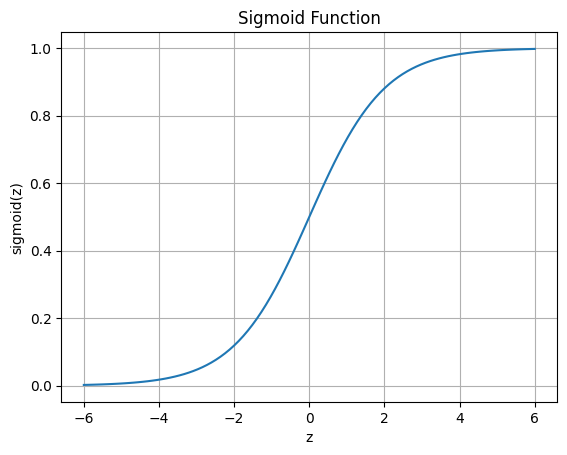

In [200]:
# Plot the sigmoid function over -6 to 6

z = np.linspace(-6, 6, 100)
sigmoid = 1 / (1 + np.exp(-z))

plt.plot(z, sigmoid)
plt.title("Sigmoid Function")
plt.xlabel("z")
plt.ylabel("sigmoid(z)")
plt.grid()
plt.show()



In statistics we usually estimate the parameters $\beta$ using maximum likelihood estimation (MLE), which is equivalent to minimizing the cross-entropy loss. For n Bernoulli distributed outcomes (independently) $y_i \in \{0,1\}$ the likelihood function for $n$ independent observations is given by:

$$
L(p) = \prod_{i=1}^n p^{y_i} (1 - p)^{1 - y_i}
$$
Taking the logarithm of the likelihood function gives us the log-likelihood:

$$
\log L(p) = \sum_{i=1}^n \left( y_i \log p + (1 - y_i) \log (1 - p) \right)
$$

## The Logistic Regression as an ANN

Just as with linear regression, the simple logistic regression model maps directly to an ANN with no hidden layers. The input layer consists of the input features, and the output layer consists of a single neuron that applies the sigmoid activation function to produce the predicted probability for class 1.

### Binary Cross-Entropy Loss

The cross-entropy loss for binary classification is known as **binary cross-entropy** (BCE) or log loss and is the negative (because the convention in optimization is to minimize the loss) log-likelihood of the Bernoulli distribution.

$$
\text{BCE}(y,\hat{y}) = - \sum_{i=1}^n \left( y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right)
$$


![Binary Classification with ANN](./figures/ann/Binary-Logistic-Regression-Head.png)

The model equation is the same as the logistic regression equation, we only rename the parameters from $\beta$ to $w$ to align with the ANN notation.

$$
\begin{align*}
z & = w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_p x_p \\
\hat{y} & = \frac{1}{1 + e^{-(z)}}
\end{align*}
$$

### Why Cross-Entropy Loss instead of MSE?


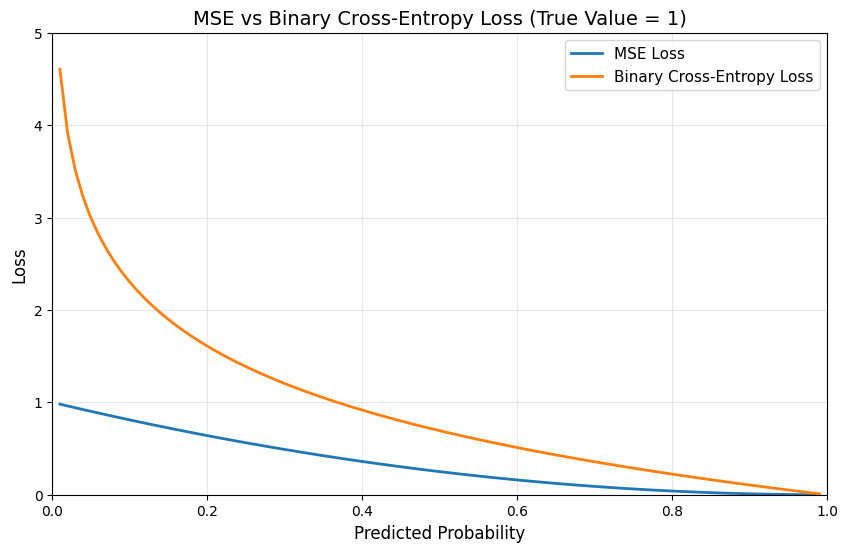

In [201]:
# Create range of predicted probabilities
p_hat = np.linspace(0.01, 0.99, 100)

# True value
y_true = 1

# Calculate MSE loss for binary classification (true value = 1)
mse_loss = (y_true - p_hat) ** 2

# Calculate Binary Cross-Entropy loss (true value = 1)
# BCE = -y*log(p_hat) - (1-y)*log(1-p_hat)
# When y=1: BCE = -log(p_hat)
bce_loss = -np.log(p_hat)

# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(p_hat, mse_loss, label='MSE Loss', linewidth=2)
plt.plot(p_hat, bce_loss, label='Binary Cross-Entropy Loss', linewidth=2)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('MSE vs Binary Cross-Entropy Loss (True Value = 1)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 5)
plt.show()

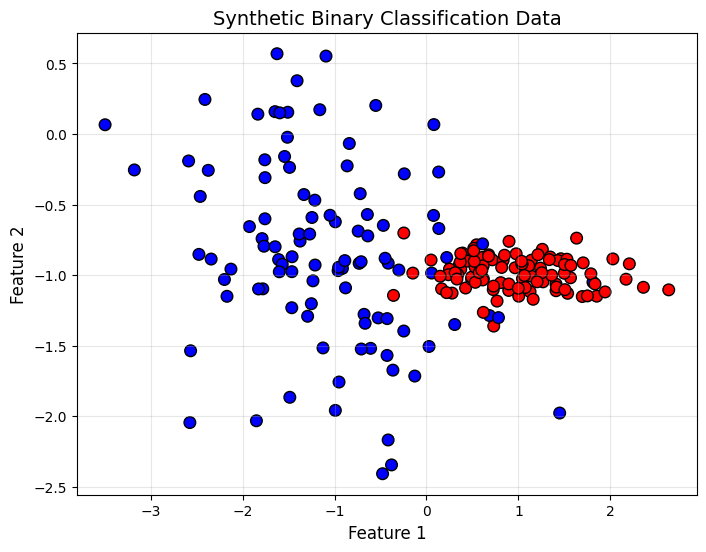

In [202]:
from sklearn.datasets import make_classification

# Generate synthetic binary classification data
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, 
                           random_state=12)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=70)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Synthetic Binary Classification Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


Epoch [100/1000], Loss: 0.3955
Epoch [200/1000], Loss: 0.3049
Epoch [300/1000], Loss: 0.2668
Epoch [400/1000], Loss: 0.2471
Epoch [500/1000], Loss: 0.2357
Epoch [600/1000], Loss: 0.2287
Epoch [700/1000], Loss: 0.2242
Epoch [800/1000], Loss: 0.2212
Epoch [900/1000], Loss: 0.2193
Epoch [1000/1000], Loss: 0.2180


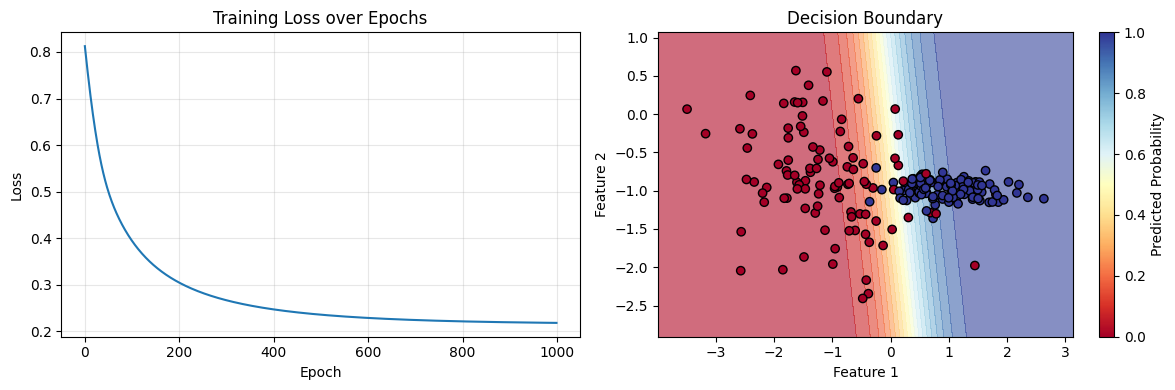

In [203]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)

# Convert to PyTorch tensors and ensure correct shapes
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).reshape(-1, 1)

##################################
## THE IMPORTANT PART IS HERE
##################################


# Define a simple neural network for binary classification
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=4):
        super(BinaryClassifier, self).__init__()
        # self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size, 1)
        
        self.fc_no_hidden = nn.Linear(input_size, 1)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        x = self.fc_no_hidden(x)    
        
        # x = self.fc1(x)
        # x = torch.relu(x)
        # x = self.fc2(x)

        x = self.sigmoid(x)
        return x

# Initialize model
model = BinaryClassifier(input_size=2, hidden_size=3)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

########################################################
## END OF THE IMPORTANT PART
## 
## The rest of the code runs gradient descent training
########################################################

# Then the loss function and the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
losses = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True, alpha=0.3)

# Plot decision boundary
plt.subplot(1, 2, 2)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    Z = model(grid).numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.colorbar(label='Predicted Probability')
plt.tight_layout()
plt.show()

In [204]:
# Show the final weights and bias

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.data.numpy()}")

fc_no_hidden.weight: [[3.1158304  0.43873653]]
fc_no_hidden.bias: [0.15909053]


Given the weights learned during training, the logistic regression model is:

$$
\hat{y} = \sigma(3.1 x_1 + 0.44 x_2 + 0.16)
$$

In [205]:
# Get the prediction for a new sample, x_1 = -2, x_2 = 3

model(torch.FloatTensor([[-2.0, 3.0]]))

tensor([[0.0085]], grad_fn=<SigmoidBackward0>)

In [206]:
1 / (1 + np.exp(-(3.1158304 * (-2) + 0.43873653 * 3 + 0.15909053)))

np.float64(0.008523563479703834)

## Multi-Class Classification with ANN

When we need to predict more than two classes (e.g. nationality, type of disease, species of an animal, etc., credit risk level: low/medium/high), we can extend the binary classification ANN by adding as many output nodes as the number of classes. Just as we used the sigmoid function to squash the logits into probabilities, we can achieve the same for multi-class classification using the **softmax** function.


<img src="./figures/ann/Multiclass-Classification-Head.png" alt="Multiclass-Softmax" width="600" />

Where $l_1, l_2, l_3$ are the output logits for classes A, B, and C respectively.


For $K$ classes, the predicted logits (one for each class) are again computed as a linear combination of the input features plus a bias, say $x_1$ and $x_2$:

$$
z = \begin{bmatrix}
z_1 \\
z_2 \\
z_3 \\
\end{bmatrix} =
\begin{bmatrix}
w_{11} x_1 + w_{12} x_2 + b_1 \\
w_{21} x_1 + w_{22} x_2 + b_2 \\
w_{31} x_1 + w_{32} x_2 + b_3 \\
\end{bmatrix}
= W x + b
$$

The predicted probabilities for each class are then obtained by applying the softmax function to the logits:

$$
\hat{y}_k = \text{softmax}(z_k) = \frac{e^{z_k}}{\sum_{j=1}^K e^{z_j}}
$$

where $x$ is a column vector of the input features, $W$ is a weight matrix where each column corresponds to the weights for one class, and $b$ is a bias vector.

$$
z = W x + b = \begin{bmatrix}
w_{11} & w_{12} \\
w_{21} & w_{22} \\
w_{31} & w_{32} \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
\end{bmatrix}
+ \begin{bmatrix}
b_1 \\
b_2 \\
b_3 \\
\end{bmatrix}
$$




$$
\hat{y}_k = \frac{e^{l_k}}{\sum_{j=1}^K e^{l_j}}
$$




In [207]:
logits = np.array([2.0, 1.0, -3])

exp_logits = np.exp(logits)
softmax_probs = exp_logits / np.sum(exp_logits)

print("Logits:", logits)
print("Exponentiated Logits:", exp_logits)
print("Softmax Probabilities:", softmax_probs)

print("Sum of Softmax Probabilities:", np.sum(softmax_probs))

Logits: [ 2.  1. -3.]
Exponentiated Logits: [7.3890561  2.71828183 0.04978707]
Softmax Probabilities: [0.72747516 0.26762315 0.00490169]
Sum of Softmax Probabilities: 1.0


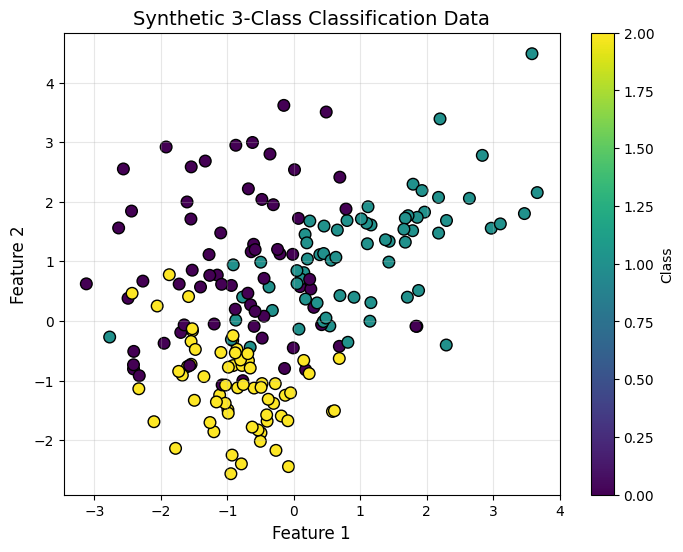

In [208]:
from sklearn.datasets import make_classification

# Generate synthetic data for 3-class classification

X_multi, y_multi = make_classification(n_samples=200, n_features=2, n_informative=2,
                                       n_redundant=0, n_clusters_per_class=1,
                                       n_classes=3, random_state=42)

# Plot the data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, cmap='viridis', 
                     edgecolor='k', s=70)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Synthetic 3-Class Classification Data', fontsize=14)
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.show()


In [209]:
X_multi[:10,]

array([[-0.37217607,  0.56938167],
       [-0.14989682,  3.61729861],
       [-0.40131003, -1.6824895 ],
       [ 3.66332221,  2.15367981],
       [ 0.16991891,  1.45195312],
       [ 2.20050588,  3.39033529],
       [-1.52430341, -0.16562994],
       [-1.54547705, -0.34450731],
       [-0.44758139,  0.71376284],
       [ 1.85205111, -0.09118106]])

In [210]:
y_multi[:10]

array([1, 0, 2, 1, 1, 1, 2, 2, 0, 1])

Epoch [200/2500], Loss: 0.5411
Epoch [400/2500], Loss: 0.5146
Epoch [600/2500], Loss: 0.5108
Epoch [800/2500], Loss: 0.5101
Epoch [1000/2500], Loss: 0.5099
Epoch [1200/2500], Loss: 0.5099
Epoch [1400/2500], Loss: 0.5099
Epoch [1600/2500], Loss: 0.5099
Epoch [1800/2500], Loss: 0.5099
Epoch [2000/2500], Loss: 0.5099
Epoch [2200/2500], Loss: 0.5099
Epoch [2400/2500], Loss: 0.5099


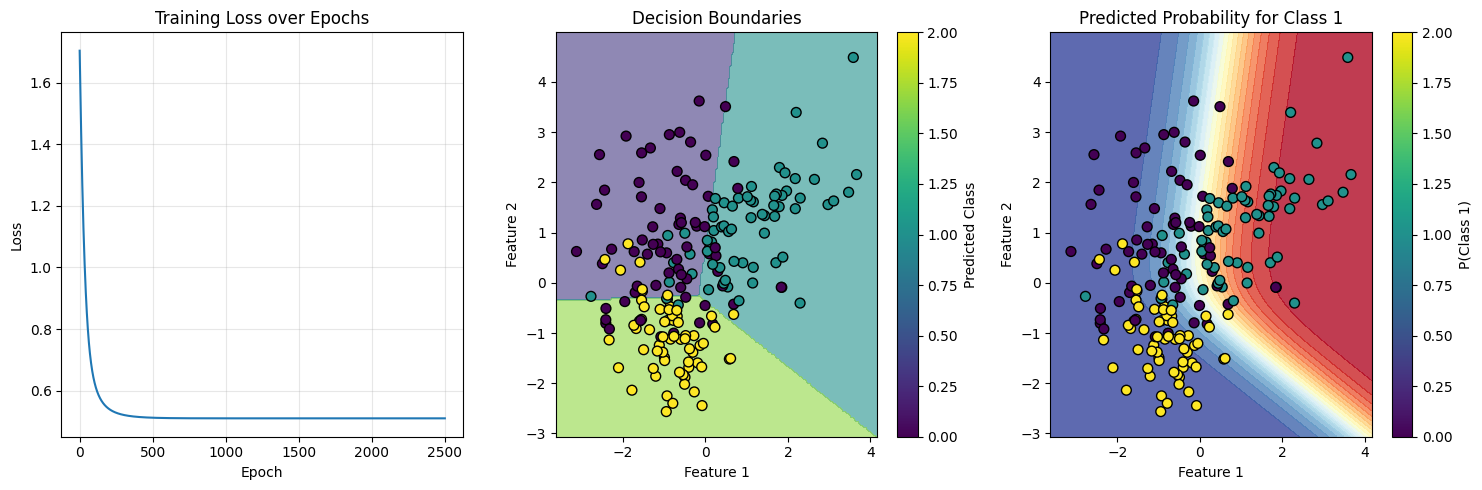


Training Accuracy: 0.8050


In [211]:
torch.manual_seed(0)

# Convert to PyTorch tensors
X_multi_tensor = torch.FloatTensor(X_multi)
y_multi_tensor = torch.LongTensor(y_multi)  # Note: LongTensor for class indices

# Define neural network for multi-class classification

################################
## THE IMPORTANT PART IS HERE
################################

class MultiClassClassifier(nn.Module):    
    def __init__(self, input_size, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, num_classes)
        
        # self.fc2 = nn.Linear(hidden_size, num_classes)
        
        # No softmax here - CrossEntropyLoss applies it internally
        
    def forward(self, x):
        x = self.fc1(x)
        # x = torch.relu(x)
        # x = self.fc2(x)  # Output logits
        return x

# Initialize the model and the loss function

model_multi = MultiClassClassifier(input_size=2, num_classes=3)

criterion_multi = nn.CrossEntropyLoss()

################################
## END OF THE IMPORTANT PART
################################

optimizer_multi = optim.Adam(model_multi.parameters(), lr=0.01)

# Training loop
epochs_multi = 2500
losses_multi = []

for epoch in range(epochs_multi):
    # Forward pass
    y_pred = model_multi(X_multi_tensor)
    loss_multi = criterion_multi(y_pred, y_multi_tensor)
    
    # Backward pass and optimization
    optimizer_multi.zero_grad()
    loss_multi.backward()
    optimizer_multi.step()
    
    losses_multi.append(loss_multi.item())
    
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs_multi}], Loss: {loss_multi.item():.4f}')

# Plot training loss and decision boundaries
plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 3, 1)
plt.plot(losses_multi)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True, alpha=0.3)

# Decision boundary
plt.subplot(1, 3, 2)
x_min_multi, x_max_multi = X_multi[:, 0].min() - 0.5, X_multi[:, 0].max() + 0.5
y_min_multi, y_max_multi = X_multi[:, 1].min() - 0.5, X_multi[:, 1].max() + 0.5
xx_multi, yy_multi = np.meshgrid(np.linspace(x_min_multi, x_max_multi, 200),
                                  np.linspace(y_min_multi, y_max_multi, 200))
grid_multi = torch.FloatTensor(np.c_[xx_multi.ravel(), yy_multi.ravel()])

with torch.no_grad():
    logits_multi = model_multi(grid_multi)
    probs_multi = torch.softmax(logits_multi, dim=1)
    predictions = torch.argmax(probs_multi, dim=1).numpy().reshape(xx_multi.shape)

plt.contourf(xx_multi, yy_multi, predictions, levels=2, cmap='viridis', alpha=0.6)
plt.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries')
plt.colorbar(label='Predicted Class')

# Predicted probabilities for each class
plt.subplot(1, 3, 3)
with torch.no_grad():
    probs_class_1 = probs_multi[:, 1].numpy().reshape(xx_multi.shape)
plt.contourf(xx_multi, yy_multi, probs_class_1, levels=20, cmap='RdYlBu_r', alpha=0.8)
plt.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Predicted Probability for Class 1')
plt.colorbar(label='P(Class 1)')

plt.tight_layout()
plt.show()

# Print accuracy
with torch.no_grad():
    predictions_train = torch.argmax(torch.softmax(model_multi(X_multi_tensor), dim=1), dim=1)
    accuracy = (predictions_train == y_multi_tensor).float().mean()
    print(f'\nTraining Accuracy: {accuracy.item():.4f}')

In [212]:
# Show the learned weights

for name, param in model_multi.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.data.numpy()}")

fc1.weight: [[-1.2330418   1.4078329 ]
 [ 0.55439603  1.1038113 ]
 [-1.1444514  -1.5016648 ]]
fc1.bias: [ 0.42070058  0.6555744  -0.29183313]


In [213]:
# Predict a new sample
new_sample = np.array([0.5, -1.0]).reshape(1, -1)
new_sample_tensor = torch.FloatTensor(new_sample)

print(f'New Sample: {new_sample_tensor.numpy()}')

logits_new = model_multi(new_sample_tensor)
print(f'Logits for New Sample: {logits_new.detach().numpy()}')

probs_new = torch.softmax(logits_new, dim=1)
predicted_class = torch.argmax(probs_new, dim=1).item()

print(f'Predicted Class: {predicted_class}, Probabilities: {probs_new.detach().numpy()}')

New Sample: [[ 0.5 -1. ]]
Logits for New Sample: [[-1.6036532  -0.17103887  0.6376059 ]]
Predicted Class: 2, Probabilities: [[0.06851754 0.28706366 0.6444188 ]]


In [235]:
# Manually reproduce the softmax calculation for the new sample using the learned weights

W = model_multi.fc1.weight.data.numpy()
b = model_multi.fc1.bias.data.numpy().reshape(3, -1)

logits_manual = W @ new_sample.T + b
exp_logits_manual = np.exp(logits_manual)

print("Manual Logits:", logits_manual)
print("Manual Exponentiated Logits:", exp_logits_manual)

softmax_manual = exp_logits_manual / np.sum(exp_logits_manual)
print("Manual Softmax Probabilities:", softmax_manual)

Manual Logits: [[-1.60365316]
 [-0.17103887]
 [ 0.63760594]]
Manual Exponentiated Logits: [[0.2011603 ]
 [0.84278882]
 [1.89194601]]
Manual Softmax Probabilities: [[0.06851754]
 [0.28706367]
 [0.6444188 ]]


In [ ]:
# For the first class:

-1.2330418 * 0.5 + 1.4078329 * (-1) + 0.42070058

-1.60365322

In [ ]:
W

array([[-1.2330418 ,  1.4078329 ],
       [ 0.55439603,  1.1038113 ],
       [-1.1444514 , -1.5016648 ]], dtype=float32)

In [ ]:
new_sample.T.shape

(2, 1)

In [ ]:
W.shape

(3, 2)

In [ ]:
W @ new_sample.T

array([[-2.02435374],
       [-0.82661325],
       [ 0.92943907]])

In [ ]:
b.shape

(3, 1)

## The Bi-Gram Model as a Logistic Regression

We can now return to our bi-gram model and see how we can implement it as a multi-class classification problem. We want to predict the second word in a sequence of two words. There are as many possibilities for the next word as there are words in the vocabulary, let say $V$. In the simple example that follows we use a tiny piece of text with only five words so that it is easy to see what the model is doing.

The only thing that is special about this classification problem is that the input vectors have a special structure: they are indicator vectors with 1 at the position of the word in the vocabulary and 0 elsewhere. For example, the
prediction of the next word after **Alice** would be done using the input vector $x_{Alice} = [1, 0, 0, 0, 0]^T$:

$$
z = W x_{Alice} + b = \begin{bmatrix}
w_{11} & w_{12} & w_{13} & w_{14} & w_{15} \\
w_{21} & w_{22} & w_{23} & w_{24} & w_{25} \\
w_{31} & w_{32} & w_{33} & w_{34} & w_{35} \\
w_{41} & w_{42} & w_{43} & w_{44} & w_{45} \\
w_{51} & w_{52} & w_{53} & w_{54} & w_{55} \\
\end{bmatrix}
\underbrace{\begin{bmatrix}
1 \\
0 \\
0 \\
0 \\
0
\end{bmatrix}}_{x_{Alice}}
+ \begin{bmatrix}
b_1 \\
b_2 \\
b_3 \\
b_4 \\
b_5 \\
\end{bmatrix}
= \begin{bmatrix}
w_{11} + b_1 \\
w_{21} + b_2 \\
w_{31} + b_3 \\
w_{41} + b_4 \\
w_{51} + b_5 \\
\end{bmatrix}
$$

Note that the matrix multiplication with the indicator vector simply selects the column of the weight matrix corresponding to position of the 1 in the indicator vector. So in this case, we are selecting the first column of the weight matrix, because the position of **Alice** in the vocabulary is 1.

$$
\hat{y} = \text{softmax}(z) = \frac{e^{z_k}}{\sum_{j=1}^V e^{z_j}}
$$


In [241]:
from nltk import word_tokenize, sent_tokenize
import re

nltk.download('punkt')
# Tokenize the text

# alice_txt_small = """
# Alice was beginning to get very tired of sitting by her sister on the
# bank, and of having nothing to do. Once or twice she had peeped into the book her
# sister was reading, but it had no pictures or conversations in it.
# """

alice_txt_small = """
Alice was beginning to get
"""

# Set up an empty list to hold the sentences
sentences = []

# Loop over each sentence in the text
for sentence in sent_tokenize(alice_txt_small):
    print(sentence)
    print("#" * 40)
    
    # Remove punctuation and convert to lowercase
    sentence_nopunct = re.sub(r'[^\w\s]', '', sentence.lower())

    # Tokenize the sentence into words and append to the list
    sentences.append(word_tokenize(sentence_nopunct.lower()))

# Flatten the list of sentences into a list of tokens so that we can create the vocabulary
# in the next step
tokens = [token for sent in sentences for token in sent]


Alice was beginning to get
########################################


[nltk_data] Downloading package punkt to /home/amarov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
for sentence in sentences:
    print(sentence)

['alice', 'was', 'beginning', 'to', 'get']


In [237]:
# Now we map tokens to integers (word indices) and create one-hot encodings

vocab = sorted(set(tokens))
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

vocab_size = len(vocab)
print("Vocabulary: ", vocab)
print(f"Vocabulary Size: {vocab_size}")

def one_hot_encode(word, word_to_idx, vocab_size):
    idx = word_to_idx[word]
    
    one_hot = np.zeros(vocab_size)
    one_hot[idx] = 1

    return one_hot

one_hot_vectors = np.array([one_hot_encode(word, word_to_idx, vocab_size) for word in tokens])

for i, word in enumerate(tokens):
    print(f"Word: {word}, One-Hot: {one_hot_vectors[i]}")


Vocabulary:  ['alice', 'beginning', 'get', 'to', 'was']
Vocabulary Size: 5
Word: alice, One-Hot: [1. 0. 0. 0. 0.]
Word: was, One-Hot: [0. 0. 0. 0. 1.]
Word: beginning, One-Hot: [0. 1. 0. 0. 0.]
Word: to, One-Hot: [0. 0. 0. 1. 0.]
Word: get, One-Hot: [0. 0. 1. 0. 0.]


In [ ]:
# Now we can prepare the data

# First we create the bigrams by looping over each word (at i) and finding its next word (at i+1)

bigrams = []

for sentence in sentences:
    for i in range(len(sentence) - 1):
        bigrams.append((sentence[i], sentence[i + 1]))

print(f"Number of bigrams: {len(bigrams)}")
print(f"First 5 bigrams: {bigrams[:5]}")

# Create training data: input is one-hot encoded current word, target is next word index
X_bigram = []
y_bigram = []

for current_word, next_word in bigrams:
    current_one_hot = one_hot_encode(current_word, word_to_idx, vocab_size)
    next_word_idx = word_to_idx[next_word]
    X_bigram.append(current_one_hot)
    y_bigram.append(next_word_idx)

X_bigram = np.array(X_bigram)
y_bigram = np.array(y_bigram)

Number of bigrams: 4
First 5 bigrams: [('alice', 'was'), ('was', 'beginning'), ('beginning', 'to'), ('to', 'get')]


In [ ]:
X_bigram

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
y_bigram

array([4, 1, 3, 2])

X_bigram shape: torch.Size([4, 5])
y_bigram shape: torch.Size([4])
Epoch [50/500], Loss: 0.0769
Epoch [100/500], Loss: 0.0287
Epoch [150/500], Loss: 0.0167
Epoch [200/500], Loss: 0.0113
Epoch [250/500], Loss: 0.0082
Epoch [300/500], Loss: 0.0063
Epoch [350/500], Loss: 0.0051
Epoch [400/500], Loss: 0.0042
Epoch [450/500], Loss: 0.0035
Epoch [500/500], Loss: 0.0030


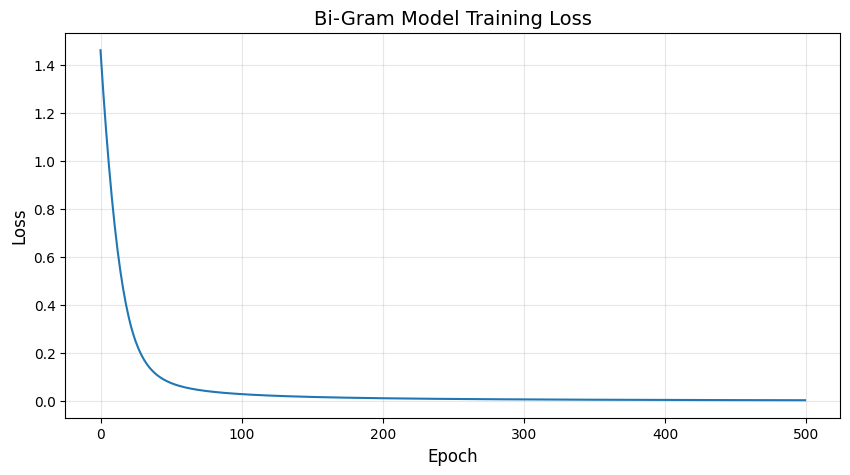

In [ ]:
# PyTorch Logistic Regression Model for Bi-Gram Language Model

# Get the data ready for PyTorch (FloatTensor for inputs, LongTensor for targets)

X_bigram_tensor = torch.FloatTensor(X_bigram)
y_bigram_tensor = torch.LongTensor(y_bigram)

# Sanity check: print the shapes of the input and target tensors
print(f"X_bigram shape: {X_bigram_tensor.shape}")
print(f"y_bigram shape: {y_bigram_tensor.shape}")

###############################
## THE IMPORTANT PART IS HERE
###############################

class BigramLogisticRegression(nn.Module):
    def __init__(self, vocab_size):
        super(BigramLogisticRegression, self).__init__()

        # Set-up a weight matrix that maps from input one-hot vector to output logits
        # The output logits must have the same size as the number of classes to predict
        # In our case this is the number of words in the vocabulary (the vocabulary size)

        self.linear = nn.Linear(vocab_size, vocab_size)
    
    def forward(self, x):
        # Output logits
        x = self.linear(x)

        # Here we simply return the logits, 
        # the softmax will be applied by CrossEntropyLoss internally

        return x

# Initialize model
bigram_model = BigramLogisticRegression(vocab_size)

bigram_criterion = nn.CrossEntropyLoss()

###############################
## END OF THE IMPORTANT PART
###############################

bigram_optimizer = optim.Adam(bigram_model.parameters(), lr=0.05)

# Training loop
epochs_bigram = 500
losses_bigram = []

for epoch in range(epochs_bigram):
    # Forward pass
    logits = bigram_model(X_bigram_tensor)
    loss = bigram_criterion(logits, y_bigram_tensor)
    
    # Backward pass
    bigram_optimizer.zero_grad()
    loss.backward()
    bigram_optimizer.step()
    
    losses_bigram.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs_bigram}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses_bigram)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Bi-Gram Model Training Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


In [101]:
# Examine what was learned

for name, param in bigram_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.data.numpy()}")

linear.weight: [[-1.7848105  -1.5774126  -0.40834677 -1.6430743  -1.5489106 ]
 [-3.7104032  -3.2869487  -0.26427218 -3.8223312   3.716641  ]
 [-3.2676902  -3.5168593  -0.27457362  3.6648147  -3.2184122 ]
 [-3.793633    3.155012   -0.40671453 -3.5803733  -3.2907283 ]
 [ 3.6169922  -3.4629729   0.1459128  -3.4699404  -2.9476023 ]]
linear.bias: [-2.1162345  1.5838578  1.375293   1.7807125  1.3892854]


In [103]:
X_bigram

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [76]:
word_to_idx

{'alice': 0, 'beginning': 1, 'get': 2, 'to': 3, 'was': 4}

In [ ]:
alice_input_vec = one_hot_encode('alice', word_to_idx, vocab_size)
print(alice_input_vec)

bigram_model(torch.FloatTensor(alice_input_vec))

[1. 0. 0. 0. 0.]


tensor([-3.9010, -2.1265, -1.8924, -2.0129,  5.0063], grad_fn=<ViewBackward0>)

In [117]:
alice_logits = bigram_model(torch.FloatTensor(np.array([1, 0, 0, 0, 0]))) # - bigram_model.linear.bias.data
alice_logits

tensor([-3.9010, -2.1265, -1.8924, -2.0129,  5.0063], grad_fn=<ViewBackward0>)

In [121]:
torch.softmax(alice_logits, dim=0)

tensor([1.3501e-04, 7.9620e-04, 1.0063e-03, 8.9201e-04, 9.9717e-01],
       grad_fn=<SoftmaxBackward0>)

In [122]:
# Extract learned bigram probabilities

W_bigram = bigram_model.linear.weight.data.numpy()
b_bigram = bigram_model.linear.bias.data.numpy()

print(f"\nWeight matrix shape: {W_bigram.shape}")
print(f"Bias vector shape: {b_bigram.shape}")

# Function to get next word probabilities given current word
def get_next_word_probs(word, word_to_idx, idx_to_word, bigram_model, vocab_size):
    word_one_hot = torch.FloatTensor(one_hot_encode(word, word_to_idx, vocab_size)).unsqueeze(0)
    
    with torch.no_grad():
        logits = bigram_model(word_one_hot)
        probs = torch.softmax(logits, dim=1).squeeze().numpy()
    
    # Create dictionary of word -> probability
    word_probs = {idx_to_word[i]: probs[i] for i in range(vocab_size)}
    
    return word_probs

# Test the model
test_word = "alice"
next_word_probs = get_next_word_probs(test_word, word_to_idx, idx_to_word, bigram_model, vocab_size)

print(f"\nPredicted probabilities for next word after '{test_word}':")
for word, prob in sorted(next_word_probs.items(), key=lambda x: x[1], reverse=True):
    print(f"  {word}: {prob:.4f}")

# Generate a sentence using the bigram model
def generate_sentence(start_word, bigram_model, word_to_idx, idx_to_word, vocab_size, max_length=10):
    sentence = [start_word]
    current_word = start_word
    
    for _ in range(max_length - 1):
        word_probs = get_next_word_probs(current_word, word_to_idx, idx_to_word, bigram_model, vocab_size)
        next_word = max(word_probs, key=word_probs.get)
        sentence.append(next_word)
        current_word = next_word
    
    return ' '.join(sentence)

generated_sentence = generate_sentence("alice", bigram_model, word_to_idx, idx_to_word, vocab_size, max_length=8)
print(f"\nGenerated sentence: {generated_sentence}")


Weight matrix shape: (5, 5)
Bias vector shape: (5,)

Predicted probabilities for next word after 'alice':
  was: 0.9972
  get: 0.0010
  to: 0.0009
  beginning: 0.0008
  alice: 0.0001

Generated sentence: alice was beginning to get was beginning to


## Softmax reduces to Sigmoid for two classes

For two logits $l_1, l_2$:

$$
\text{softmax}(l_1) = \frac{e^{l_1}}{e^{l_1}+e^{l_2}},\quad
\text{softmax}(l_2) = \frac{e^{l_2}}{e^{l_1}+e^{l_2}}
$$

Divide numerator and denominator of $\text{softmax}(l_2)$ by $e^{l_1}$:

$$
\text{softmax}(l_2)
= \frac{e^{l_2-l_1}}{1 + e^{l_2-l_1}}
= \sigma(l_2 - l_1)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid. Likewise,
$\text{softmax}(l_1) = 1 - \sigma(l_2 - l_1)$.